# Import edilmesi gereken moduller

In [1]:
# TensorFlow kütüphanesinin belirli bir sürümünü yükler
! pip install tensorflow==2.9.1


ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.1 (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.9.1


In [2]:
# Sistem kütüphanelerini import etme
import os         # İşletim sistemi işlevleri için
import time       # Zaman işlemleri için
import shutil     # Dosya ve dizin işlemleri için
import pathlib    # Dosya yolu işlemleri için
import itertools  # İterasyon işlemleri için
from PIL import Image  # Resim işlemleri için

# Veri işleme araçlarını import etme
import cv2                 # Görüntü işleme için OpenCV kütüphanesi
import numpy as np         # Sayısal işlemler için
import pandas as pd        # Veri analizi ve işleme için
import seaborn as sns      # Veri görselleştirme için
sns.set_style('darkgrid')  # seaborn görsel stilini ayarlama
import matplotlib.pyplot as plt   # Görselleştirme için
from sklearn.model_selection import train_test_split    # Veri setini eğitim ve test setlerine ayırmak için
from sklearn.metrics import confusion_matrix, classification_report   # Sınıflandırma metrikleri için

# Derin öğrenme kütüphaneleri import etme
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Uyarıları Görmezden Gel
import warnings
warnings.filterwarnings("ignore")

print('Modüller başarıyla yüklendi.')  # Modüllerin yüklendiğine dair bir bildirim


Modüller başarıyla yüklendi.


# **Veri Önİşleme**

### **Veri okuma ve saklama**

In [3]:
# Veri yolunu oluşturma
data_dir = os.path.join(os.path.expanduser('~'), 'Desktop', 'lung_colon_image_set', 'colon_image_sets')

# Dosya yollarını ve etiketleri depolamak için boş listeler oluşturun
filepaths = []
labels = []

# Veri setindeki klasörlerin her birini döngüye al
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    # Her klasördeki dosyaları döngüye al
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        # Dosya yolunu listeye ekle
        filepaths.append(fpath)
        # Etiketi listeye ekle
        labels.append(fold)

# Dosya yollarını ve etiketleri bir veri çerçevesinde birleştir
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [4]:
df  # Dosya yollarını ve etiketleri içeren veri çerçevesini görüntüler

filepaths     labels
0     C:\Users\Fatih\Desktop\lung_colon_image_set\co...  colon_aca
1     C:\Users\Fatih\Desktop\lung_colon_image_set\co...  colon_aca
2     C:\Users\Fatih\Desktop\lung_colon_image_set\co...  colon_aca
3     C:\Users\Fatih\Desktop\lung_colon_image_set\co...  colon_aca
4     C:\Users\Fatih\Desktop\lung_colon_image_set\co...  colon_aca
...                                                 ...        ...
9995  C:\Users\Fatih\Desktop\lung_colon_image_set\co...    colon_n
9996  C:\Users\Fatih\Desktop\lung_colon_image_set\co...    colon_n
9997  C:\Users\Fatih\Desktop\lung_colon_image_set\co...    colon_n
9998  C:\Users\Fatih\Desktop\lung_colon_image_set\co...    colon_n
9999  C:\Users\Fatih\Desktop\lung_colon_image_set\co...    colon_n

[10000 rows x 2 columns]

### **Verisetini eğitim,doğrulama ve test olarak ayırma**

In [5]:
# Eğitim veri çerçevesi
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# Doğrulama ve test veri çerçeveleri
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)


### **Görüntü veri jeneratörü oluşturma**

In [6]:
# Kırpılmış görüntü boyutu
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Eğitim ve test veri jeneratörlerini oluşturma
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Eğitim, doğrulama ve test veri jeneratörlerini oluşturma
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 8000 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


### **Eğitim datasından bazı örnekler göster**

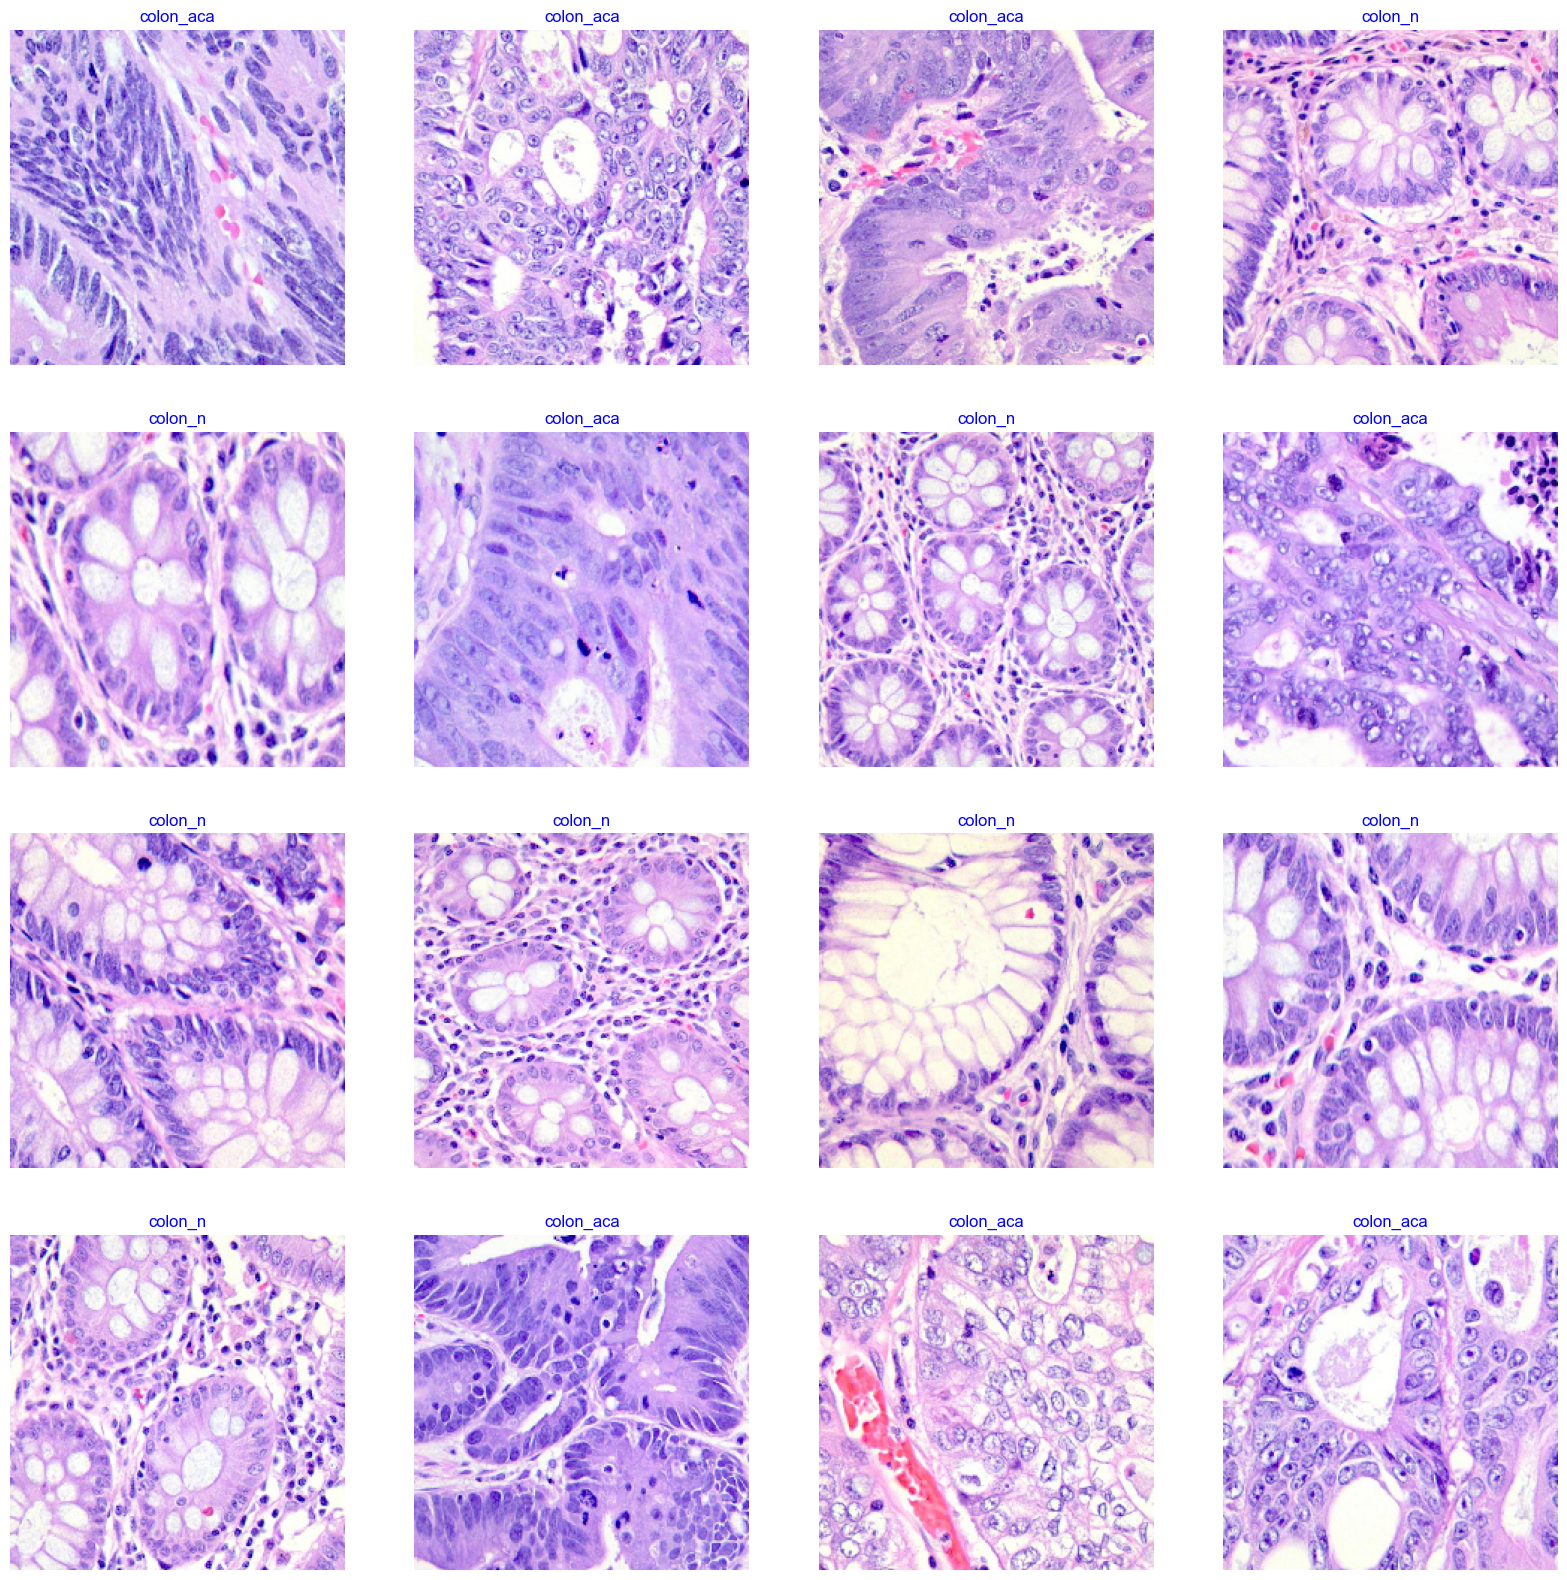

In [7]:
# Eğitim veri jeneratöründen sınıf endekslerini alır (dictionary olarak)
g_dict = train_gen.class_indices

# Sınıf isimlerini içeren bir liste oluşturur
classes = list(g_dict.keys())

# Veri jeneratöründen bir batch boyutundaki örnekleri alır
images, labels = next(train_gen)

# Görüntüleri ve etiketleri görselleştirme
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # veriyi (0 - 255) aralığına ölçekler
    plt.imshow(image)
    index = np.argmax(labels[i])  # görüntünün endeksini alır
    class_name = classes[index]   # görüntünün sınıfını alır
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


# **Model Yapısı**

#### **Genel Model Oluşturma**

In [8]:
# Model Yapısını Oluşturma
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Yoğun katmandaki sınıf sayısını tanımlamak için

# Biz EfficientNet ailesinden efficientnetb3 modelini kullanacağız.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

#### **Modeli Eğitme**

In [9]:
epochs = 10  # eğitimdeki toplam epoch sayısı

history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, 
                    validation_steps=None, shuffle=False)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 925s 2s/step - accuracy: 0.7855 - loss: 8.8120 - val_accuracy: 0.9692 - val_loss: 3.7515
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 869s 2s/step - accuracy: 0.9259 - loss: 3.0291 - val_accuracy: 1.0000 - val_loss: 1.5889
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.9390 - loss: 1.4111 - val_accuracy: 0.9692 - val_loss: 0.8196
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.9033 - loss: 0.8146 - val_accuracy: 0.9667 - val_loss: 0.5236
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.9120 - loss: 0.5708 - val_accuracy: 0.9958 - val_loss: 0.3719
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.9307 - loss: 0.4502 - val_accuracy: 0.9983 - val_loss: 0.3069
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.9252 - loss: 0.4033 - val_accuracy: 0.9808 - val_loss: 0.2793
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 906s 2s/step - accuracy: 0.9120 - loss: 0.3680 - val_accu

#### **Model Performansını Görüntüleme**

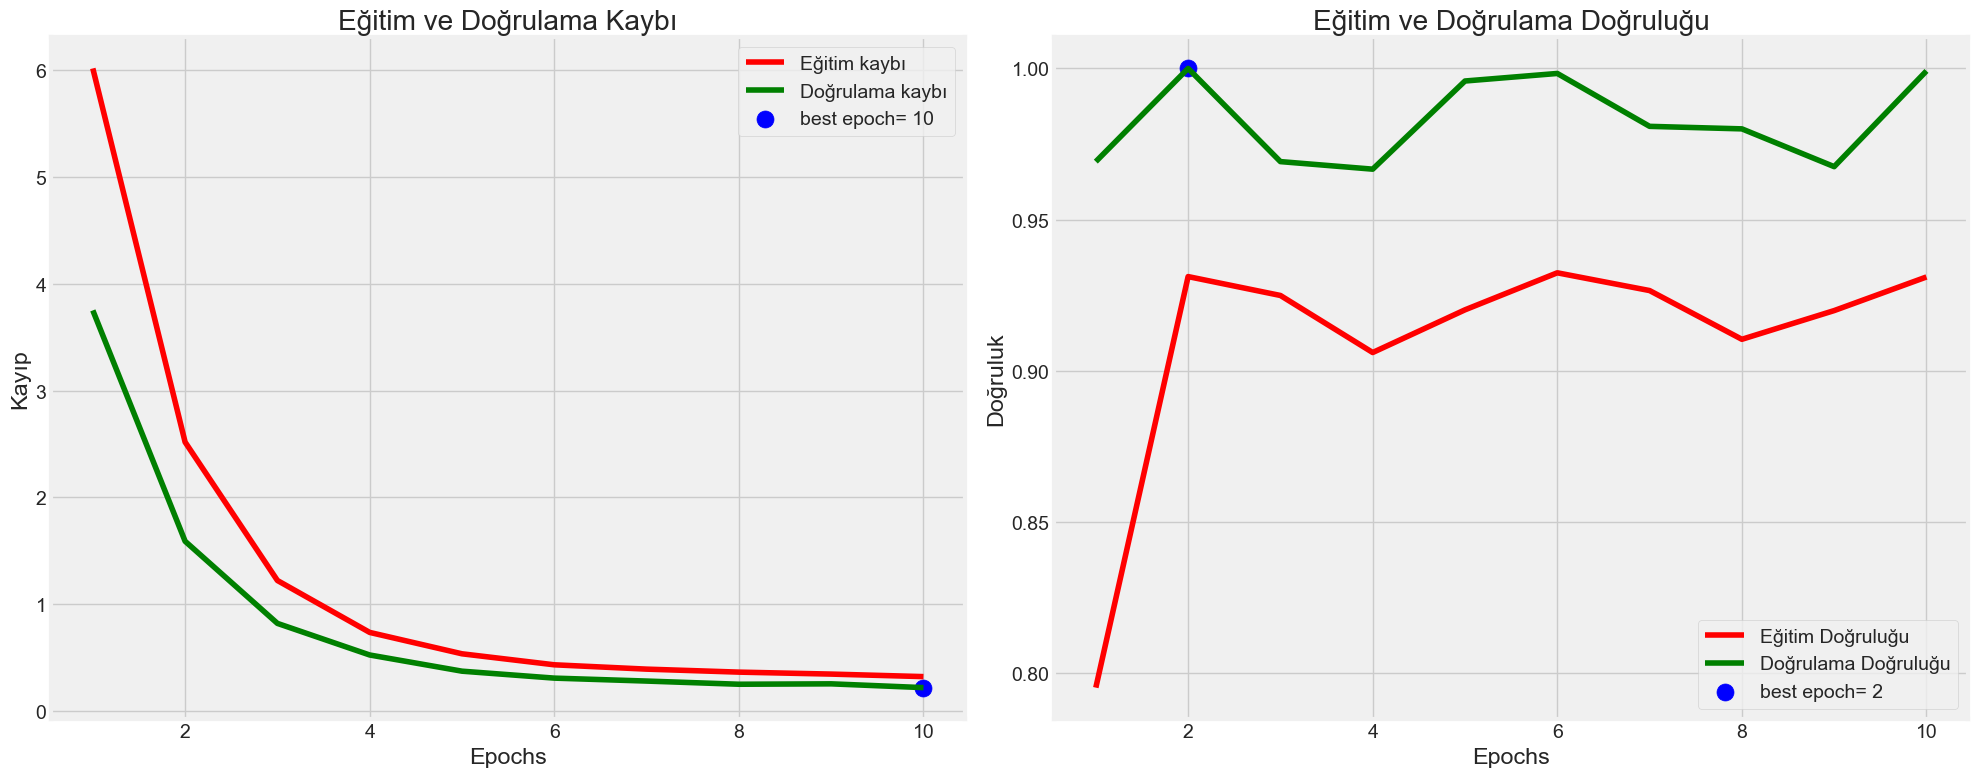

In [10]:
# Gerekli değişkenleri tanımlama
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Eğitim geçmişini görselleştirme
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Eğitim kaybı')
plt.plot(Epochs, val_loss, 'g', label='Doğrulama kaybı')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Eğitim Doğruluğu')
plt.plot(Epochs, val_acc, 'g', label='Doğrulama Doğruluğu')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


# **Modeli Geliştirme**

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Eğitim, doğrulama ve test setleri için ölçüm adımlarını hesaplar

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1) # Eğitim seti için modelin performansını değerlendirir
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1) # Doğrulama seti için modelin performansını değerlendirir
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1) # Test seti için modelin performansını değerlendirir

print("Eğitim Kaybı: ", train_score[0]) # Eğitim seti kaybını yazdırır
print("Eğitim Doğruluğu: ", train_score[1]) # Eğitim seti doğruluğunu yazdırır
print('-' * 20)
print("Doğrulama Kaybı: ", valid_score[0]) # Doğrulama seti kaybını yazdırır
print("Doğrulama Doğruluğu: ", valid_score[1]) # Doğrulama seti doğruluğunu yazdırır
print('-' * 20)
print("Test Kaybı: ", test_score[0]) # Test seti kaybını yazdırır
print("Test Doğruluğu: ", test_score[1]) # Test seti doğruluğunu yazdırır


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.9975 - loss: 0.2147
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 1.0000 - loss: 0.2249
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.9975 - loss: 0.2115
Eğitim Kaybı:  0.21819743514060974
Eğitim Doğruluğu:  0.9937499761581421
--------------------
Doğrulama Kaybı:  0.2186778038740158
Doğrulama Doğruluğu:  1.0
--------------------
Test Kaybı:  0.2155332863330841
Test Doğruluğu:  0.9937499761581421


# **Tahminleri Al**

In [12]:
# Tahminleri al
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step


#### **Karışıklık Matrisi ve Sınıflandırma Raporu**

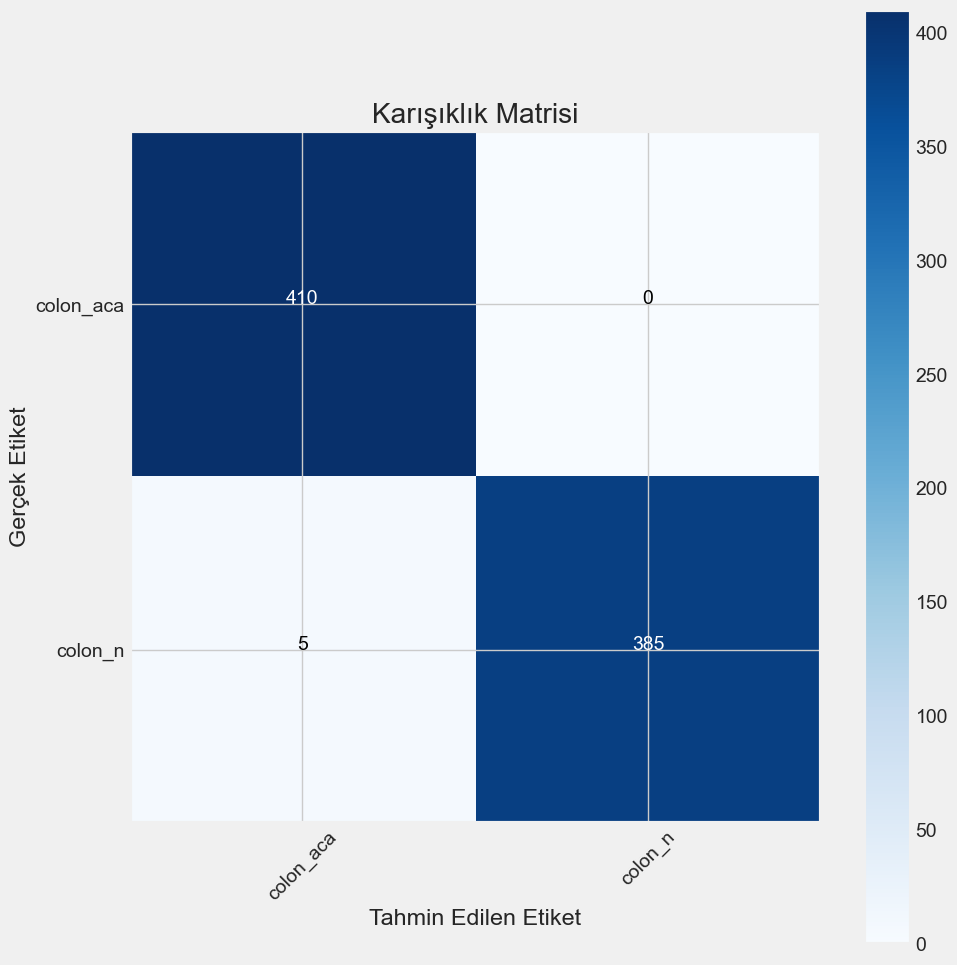

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Karışıklık matrisi
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Karışıklık Matrisi')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')

plt.show()


In [14]:
# Sınıflandırma raporu
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   colon_aca       0.99      1.00      0.99       410
     colon_n       1.00      0.99      0.99       390

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



#### **Save model**

In [15]:
#Modeli Kaydet
model.save('Colon_cancer.keras')

## **Modeli kullanarak tahmin etme**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adamax  # Adamax optimizer'ını içe aktar

# Modeli yeniden oluşturma
loaded_model = Sequential([
    # Burada giriş boyutunu belirtin
    Dense(256, input_shape=(256,), activation='relu'), 
    # Diğer katmanları ekleyin
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Çıkış katmanı için uygun boyutta birim sayısı belirtin
])

# Modeli derleme
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
from PIL import Image

# Görüntüyü yükleyin
image_path = 'C:\\Users\\Fatih\\Desktop\\lung_colon_image_set\\colon_image_sets\\colon_aca\\colonca11.jpeg'
image = Image.open(image_path)

# Görüntüyü 224x224 boyutuna yeniden boyutlandırın
resized_image = image.resize((224, 224))

# Görüntüyü numpy dizisine dönüştürün
img_array = np.array(resized_image) / 255.0  # Normalleştirme
img_array = np.expand_dims(img_array, axis=0)  # Batch boyutunu ekleyin

# Tahmin işlemi
predictions = model.predict(img_array)

# Sınıf etiketlerini alın
class_labels = ['Colon_ACA','Lung_N']
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

print("Tahmin Edilen Sınıf Etiketi:", predicted_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tahmin Edilen Sınıf Etiketi: Colon_ACA
